In [1]:
import cython

In [2]:
print(cython.__version__)

3.0.10


In [3]:
%load_ext cython

In [4]:
%%cython -f -a
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np

np.import_array()

from libc.stdio cimport printf
from libc.string cimport memcpy
from libcpp cimport bool as cpp_bool
from libcpp.limits cimport numeric_limits


from CyRK.utils.memory cimport shared_ptr, make_shared
from CyRK.utils.vector cimport vector
from CyRK.array.interp cimport interpj_ptr, interp_ptr, interp_complex_ptr
from CyRK cimport cysolve_ivp, CySolveOutput, PreEvalFunc, CySolverResult

from TidalPy.utilities.math.complex cimport cmplx_NAN, cf_build_dblcmplx

cdef double INF_DBL = numeric_limits[double].infinity()
cdef double PI_DBL = 3.14159265359
cdef double G = 6.67430e-11
cdef double NAN_DBL = cmplx_NAN.real

cdef struct interpolate_input:
    size_t num_slices
    double* radius_array_ptr
    double* density_array_ptr
    double complex* bulk_modulus_array_ptr
    double complex* shear_modulus_array_ptr

cdef struct EOSOutput:
    double density
    double complex bulk_modulus
    double complex shear_modulus

cdef void preeval_interpolate(
        # Values that will be updated by the function
        void* preeval_output,
        # Input that is used by the pre-eval
        double radius,
        double* radial_solutions,
        const void* preeval_input
        ) noexcept nogil:

    # Cast input to the proper structure for this function
    cdef EOS_ODEInput* ode_args = <EOS_ODEInput*>preeval_input
    cdef interpolate_input* eos_data = <interpolate_input*>ode_args.eos_input_ptr

    # Cast output to the proper structure
    cdef EOSOutput* output = <EOSOutput*>preeval_output

    # Set state variables based on an interpolation using the provided radius.
    # The first interpolation will be the slowest as it must find the closest index.
    # We will use this index in the other interpolations.
    cdef (double, Py_ssize_t) interp_out = interpj_ptr(
        radius,
        eos_data.radius_array_ptr,
        eos_data.density_array_ptr,
        eos_data.num_slices,
        provided_j=-2
        )

    cdef Py_ssize_t index_j
    output.density = interp_out[0]
    index_j        = interp_out[1]

    # TODO: Interpolate the static bulk and shear mod; interpolate the bulk and shear viscosity, then apply rheology here.
    cdef double complex complex_bulk
    if ode_args.update_bulk:
        complex_bulk = interp_complex_ptr(
            radius,
            eos_data.radius_array_ptr,
            eos_data.bulk_modulus_array_ptr,
            eos_data.num_slices,
            provided_j=index_j
            )
        
        output.bulk_modulus = complex_bulk
    else:
        output.bulk_modulus = cmplx_NAN

    cdef double complex complex_shear
    if ode_args.update_shear:
        complex_shear = interp_complex_ptr(
            radius,
            eos_data.radius_array_ptr,
            eos_data.shear_modulus_array_ptr,
            eos_data.num_slices,
            provided_j=index_j
            )

        # Apply shear rheology
        output.shear_modulus = complex_shear
    else:
        output.shear_modulus = cmplx_NAN

    # Done

        
cdef struct EOS_ODEInput:
    double G_to_use
    double planet_radius
    void* eos_input_ptr
    cpp_bool final_solve
    cpp_bool update_bulk
    cpp_bool update_shear


cdef struct GlobalEOSSolutionStorage:
    vector[double] radius
    vector[double] pressure
    vector[double] gravity
    vector[double] density
    vector[double] static_shear_modulus
    vector[double] shear_viscosity
    vector[double complex] complex_shear_modulus
    vector[double] static_bulk_modulus
    vector[double] bulk_viscosity
    vector[double complex] complex_bulk_modulus

ctypedef shared_ptr[GlobalEOSSolutionStorage] GlobalEOSSolution


cdef void eos_solution(
        double* dy_ptr,
        double radius,
        double* y_ptr,
        const void* input_args,
        PreEvalFunc eos_function) noexcept nogil:
    """ Solve for EOS components as a function of radius. """

    # Cast input args to correct structure type
    cdef EOS_ODEInput* eos_input_ptr = <EOS_ODEInput*>input_args

    # Other constants
    cdef double grav_coeff = 4. * PI_DBL * eos_input_ptr.G_to_use

    # Update viscoelastic parameters using the user-provided equation of state
    cdef EOSOutput eos_output
    cdef EOSOutput* eos_output_ptr = &eos_output 
    eos_function(eos_output_ptr, radius, y_ptr, input_args)
    
    cdef double rho = eos_output.density
    
    # Solve for gravity and pressure
    if (radius <= 0.)  or (radius > eos_input_ptr.planet_radius):
        dy_ptr[0] = 0.0
        dy_ptr[1] = 0.0
    else:
        # Acceleration due to Gravity
        dy_ptr[0] = grav_coeff * rho - 2.0 * y_ptr[0] * (1.0 / radius)

        # Pressure
        dy_ptr[1] = -rho * y_ptr[0]

    # TODO: Track the static shear and bulk as well as the bulk and shear viscosity as additional outputs.
    if eos_input_ptr.final_solve:
        # There are two real dy/dt: gravity and pressure and then 9 additional parameters that are saved but
        # not used during integration but which the user may want for reference.
        dy_ptr[2] = eos_output.density

        dy_ptr[3] = eos_output.shear_modulus.real
        dy_ptr[4] = eos_output.shear_modulus.imag

        dy_ptr[5] = eos_output.bulk_modulus.real
        dy_ptr[6] = eos_output.bulk_modulus.imag

cdef vector[CySolveOutput] solve_eos(
        double* radius_array_ptr,
        size_t len_radius_array,
        double* layer_upper_radii,
        unsigned int num_layers,
        PreEvalFunc* eos_function_bylayer_ptrs,
        EOS_ODEInput** eos_input_bylayer_ptrs,
        double planet_bulk_density,
        double surface_pressure = 0.0,
        double G_to_use = G,
        unsigned int integration_method = 2,
        double rtol = 1.0e-8,
        double atol = 1.0e-16,
        double pressure_tol = 1.0e-3,
        unsigned int max_iters = 100
        ) noexcept nogil:

    # Don't use rtol or atol arrays
    cdef double[2] rtols_arr = [1.0e-8, 1.0e-12]
    cdef double[2] atols_arr = [1.0e-10, 1.0e-15]
    cdef double* rtols_ptr = NULL #&rtols_arr[0]
    cdef double* atols_ptr = NULL #&atols_arr[0]
    
    # Determine planetary properties
    cdef double planet_radius = radius_array_ptr[len_radius_array - 1]
    cdef double r0_gravity = 0.0
    cdef double r0_pressure_guess = \
        surface_pressure + \
        (2. / 3.) * PI_DBL * G_to_use * planet_radius * planet_radius * planet_bulk_density * planet_bulk_density
    
    # Setup bound variables
    cdef double[2] radial_span
    cdef double* radial_span_ptr = &radial_span[0]

    # We need the centeral pressure of the planet. Use the global bulk modulus to calculate this.
    cdef double[2] y0 = [r0_gravity, r0_pressure_guess]
    cdef double* y0_ptr = &y0[0]

    # y information
    cdef unsigned int num_y = 2
    cdef unsigned int num_extra = 0

    # Layer information
    cdef unsigned int layer_i
    cdef size_t top_of_last_layer_index
    cdef double[2] y0_layer
    cdef double* y0_layer_ptr = &y0_layer[0]

    # EOS functions and inputs
    cdef void* args_ptr = NULL
    cdef PreEvalFunc eos_function_ptr = NULL
    cdef EOS_ODEInput* eos_input_layer_ptr = NULL
    
    # Other integration information
    cdef size_t max_num_steps  = 10_000
    cdef size_t max_ram_MB     = 500
    cdef bint use_dense_output = False
    cdef double max_step       = 0.3 * planet_radius / num_layers
    cdef double first_step     = 0.0
    cdef size_t expected_size  = 50
    cdef double* t_eval_ptr    = NULL
    cdef size_t len_t_eval     = 0
    
    # Pressure convergence variables
    cdef size_t surface_pressure_index = 0
    cdef double calculated_surf_pressure = INF_DBL
    cdef double pressure_diff = INF_DBL
    cdef unsigned int iterations = 0
    cdef cpp_bool failed = False
    cdef cpp_bool max_iters_hit = False
    cdef cpp_bool final_run = False
    
    # Integration solution variables
    cdef size_t last_solution_size = 0
    cdef CySolveOutput solution
    cdef CySolverResult* solution_ptr = NULL
    cdef vector[CySolveOutput] layer_solutions = vector[CySolveOutput](0)
    layer_solutions.reserve(num_layers)
    
    
    
    cdef size_t i
    
    
    while True:
        
        if not final_run:
            iterations += 1
#         printf("\n\nNEW IT\n")
        # Step through each macro layer of the planet and solve for density and gravity
        for layer_i in range(num_layers):
#             printf("\t\tDEBUG-Layer %d\n", layer_i)
            
            # Setup bounds and initial conditions for next layer's integration
            radial_span_ptr[1] = layer_upper_radii[layer_i]
            if layer_i == 0:
                radial_span_ptr[0] = 0.0
                # Set y0 for bottom-most layer equal to the global y0
                y0_layer_ptr[0] = y0_ptr[0]
                y0_layer_ptr[1] = y0_ptr[1]
            else:
                radial_span_ptr[0] = layer_upper_radii[layer_i - 1]
                top_of_last_layer_index = (num_extra + num_y) * (last_solution_size - 1)
                # y0 for this layer equals result of last layer
                y0_layer_ptr[0] = solution_ptr.solution[top_of_last_layer_index]
                y0_layer_ptr[1] = solution_ptr.solution[top_of_last_layer_index + 1]
                
#                 printf("\t\tDEBUG-Layer %d:: y0=%e, y1=%e\n", layer_i, y0_layer_ptr[0], y0_layer_ptr[1])
            
            # Get eos function and inputs for this layer
            eos_input_layer_ptr = eos_input_bylayer_ptrs[layer_i]
            eos_function_ptr    = eos_function_bylayer_ptrs[layer_i]
            
            # Convert input pointer to void pointer (required by cysolve)
            args_ptr = <void*>eos_input_layer_ptr
#             memcpy(eos_input_ptr, <void*>eos_input_layer_ptr, sizeof(EOS_ODEInput))
            
            if final_run:
                # We now want to make sure that all final calculations are performed.
                eos_input_layer_ptr.update_bulk = True
                eos_input_layer_ptr.update_shear = True
                eos_input_layer_ptr.final_solve = True
                # Capture extra outputs and store interpolators
                num_extra = 5
                use_dense_output = True
            else:
                # During the iterations we do not need to update the complex bulk or shear
                eos_input_layer_ptr.update_bulk = False
                eos_input_layer_ptr.update_shear = False
                # We also are not at the final call step. 
                eos_input_layer_ptr.final_solve = False
                num_extra = 0
                use_dense_output = False
            
#             printf("\t\t LIND:: r_span = %e, %e\n", radial_span_ptr[0], radial_span_ptr[1])
            solution = cysolve_ivp(
                eos_solution, radial_span_ptr, y0_layer_ptr, num_y,
                integration_method, rtol, atol, args_ptr, num_extra,
                max_num_steps, max_ram_MB, use_dense_output, t_eval_ptr, len_t_eval, eos_function_ptr,
                rtols_ptr, atols_ptr, max_step, first_step, expected_size)
            solution_ptr = solution.get()
            last_solution_size = solution_ptr.size

#             printf("\t\tDEBUG:: Integration Msg: %s\n", solution_ptr.message_ptr)
#             printf("\t\tDEBUG:: Size = %d\n", solution_ptr.size)
#             for i in range(solution_ptr.size):
#                 printf("\t\t\t %d:: r = %e g = %e P = %e\n", 2 * i + 1, solution_ptr.time_domain[i], solution_ptr.solution[(num_y + num_extra) * i], solution_ptr.solution[(num_y + num_extra) * i + 1])

            if not solution_ptr.success:
                failed = True
                break
            
            if final_run:
                layer_solutions.push_back(solution)

        if failed:
            break
        
        if final_run:
            # We are done!
            break
        else:
            surface_pressure_index = num_y * last_solution_size - 1
            calculated_surf_pressure = solution_ptr.solution[surface_pressure_index]

            # Update the centeral pressure using the error at the surface as the correction factor
            pressure_diff = surface_pressure - calculated_surf_pressure
            pressire_diff_abs = pressure_diff
            if pressure_diff < 0.0:
                pressire_diff_abs = -pressure_diff
                
#             printf("DEBUG:: S = %e; D = %e\n", calculated_surf_pressure, pressure_diff)
            y0_ptr[1] += pressure_diff

            # Calculate percent difference to use in convergence check.
            if surface_pressure != 0.0:
                pressire_diff_abs /= surface_pressure
                
            # Check if we are done next iteration
            if pressire_diff_abs <= pressure_tol:
                final_run = True
        
        if iterations >= max_iters:
            max_iters_hit = True
            # To ensure that there is some output we will go ahead and do a final run.
            final_run = True
    
    # Display any warnings
    if max_iters_hit:
        printf("Warning in `solve_eos`: Maximum number of iterations hit without convergence.\n")
    
    if failed:
        if solution_ptr:
            printf("Warning in `solve_eos`: Integrator failed at iteration %d. Message: %s\n", iterations, solution_ptr.message_ptr)
        else:
            printf("Warning in `solve_eos`: Integrator failed at iteration %d.\n", iterations)
    
#     printf("Max Iters = %d\n", iterations)
    
    return layer_solutions



cdef cpp_bool non_dim = True

cdef double R_P = 6000.e3
cdef double planet_rad_touse = R_P
cdef unsigned int num_layers = 3
cdef double planet_bulk_density = 3500.
cdef double planet_bulk_density_touse = planet_bulk_density
cdef double surface_pressure = 0.0
cdef double surface_pressure_touse = surface_pressure
cdef double G_to_use = G
cdef unsigned int integration_method = 2
cdef double rtol = 1.0e-8
cdef double atol = 1.0e-16
cdef double pressure_tol = 1.0
cdef unsigned int max_iters = 100

cdef size_t len_radius_array = 200

radius_array_arr = np.linspace(0.0, R_P, len_radius_array)
density_array_arr = np.linspace(4000., 2000, len_radius_array)
shear_array_arr = np.linspace(100.0e9, 75.0e9, len_radius_array, dtype=np.complex128)
bulk_array_arr = np.linspace(200.0e9, 175.0e9, len_radius_array, dtype=np.complex128)

density_array_arr[radius_array_arr <= 0.75 * R_P] = 8000.
density_array_arr[radius_array_arr <= 0.25 * R_P] = 13000.

planet_bulk_density = np.average(density_array_arr)

cdef double[::1] radius_array_view = radius_array_arr
cdef double* radius_array_ptr = &radius_array_view[0]

cdef double[::1] density_array_view = density_array_arr
cdef double* density_array_ptr = &density_array_view[0]

cdef double complex[::1] shear_array_view = shear_array_arr
cdef double complex* shear_array_ptr = &shear_array_view[0]

cdef double complex[::1] bulk_array_view = bulk_array_arr
cdef double complex* bulk_array_ptr = &bulk_array_view[0]

cdef vector[PreEvalFunc] eos_function_bylayer = vector[PreEvalFunc]()
eos_function_bylayer.push_back(preeval_interpolate)
eos_function_bylayer.push_back(preeval_interpolate)
eos_function_bylayer.push_back(preeval_interpolate)

cdef PreEvalFunc* eos_function_ptrs = &eos_function_bylayer[0]

cdef interpolate_input eos_input
cdef double second2_conversion, second_conversion, length_conversion
cdef double density_conversion, mass_conversion, pascal_conversion
if non_dim:
    G_to_use = 1.0 / PI_DBL
    planet_rad_touse = 1.0
    planet_bulk_density_touse = 1.0
    second2_conversion = 1. / (PI_DBL * G * planet_bulk_density)
    second_conversion  = sqrt(second2_conversion)
    length_conversion  = R_P
    density_conversion = planet_bulk_density
    mass_conversion    = planet_bulk_density * R_P**3
    pascal_conversion  = mass_conversion / (length_conversion * second2_conversion)
from libc.math cimport sqrt
cdef size_t i
if non_dim:
    surface_pressure_touse = surface_pressure / pascal_conversion
    pressure_tol /= pascal_conversion
    print(pressure_tol)
    for i in range(len_radius_array):
        radius_array_ptr[i] /= length_conversion
        density_array_ptr[i] /= density_conversion
        bulk_array_ptr[i] /= pascal_conversion
        shear_array_ptr[i] /= pascal_conversion

cdef vector[double] layer_upper_radii = vector[double]()
layer_upper_radii.push_back(0.25 * planet_rad_touse)
layer_upper_radii.push_back(0.75 * planet_rad_touse)
layer_upper_radii.push_back(planet_rad_touse)
cdef double* layer_upper_radii_ptr = &layer_upper_radii[0]
        

eos_input.num_slices = len_radius_array
eos_input.radius_array_ptr = radius_array_ptr
eos_input.density_array_ptr = density_array_ptr
eos_input.bulk_modulus_array_ptr = bulk_array_ptr
eos_input.shear_modulus_array_ptr = shear_array_ptr

cdef interpolate_input* eos_preeval_input_ptr = &eos_input

cdef EOS_ODEInput eos_ode_input

eos_ode_input.G_to_use = G_to_use

eos_ode_input.planet_radius = planet_rad_touse
eos_ode_input.eos_input_ptr = <void*>eos_preeval_input_ptr

eos_ode_input.final_solve = False
eos_ode_input.update_bulk = False
eos_ode_input.update_shear = False


cdef EOS_ODEInput* eos_ode_input_ptr = &eos_ode_input

ctypedef EOS_ODEInput* EOS_ODEInput_Ptr 

cdef vector[EOS_ODEInput_Ptr] eos_ode_input_layers = vector[EOS_ODEInput_Ptr]()

eos_ode_input_layers.push_back(eos_ode_input_ptr)
eos_ode_input_layers.push_back(eos_ode_input_ptr)
eos_ode_input_layers.push_back(eos_ode_input_ptr)

cdef EOS_ODEInput** eos_ode_input_layers_ptr = &eos_ode_input_layers[0]

cdef vector[CySolveOutput] Output

cdef void interpolate_from_solution_list(
        double* y_result_ptr,
        int num_y,
        vector[CySolveOutput] solution_list_vec,
        int num_solutions,
        double* x_domain_ptr,
        size_t x_domain_size,
        vector[double] x_breakpoints_vec) noexcept nogil:
    """ Steps through multiple cysolve solutions to interpolate using a single all-domain domain. """
    
    cdef size_t x_i
    cdef double x
    cdef int current_sol_i = 0
    cdef double current_sol_upper_x = x_breakpoints_vec[0]
    cdef double* y_result_subptr = y_result_ptr
    cdef CySolverResult* cy_solution_ptr = solution_list_vec[0].get()
    
    for x_i in range(x_domain_size):
        
        x = x_domain_ptr[x_i]
        if x > current_sol_upper_x:
            # We are ready for the next solution.
            current_sol_i += 1
            current_sol_upper_x = x_breakpoints_vec[current_sol_i]
            cy_solution_ptr = solution_list_vec[current_sol_i].get()
        
        # Run cysolver interpolator
        y_result_subptr = &y_result_ptr[x_i * num_y]
        cy_solution_ptr.call(x, y_result_subptr)

y_result_arr = np.zeros(7 * len_radius_array, dtype=np.float64)
cdef double[::1] y_result_view = y_result_arr
cdef double* y_result_ptr = &y_result_view[0]


def run():
    Output = solve_eos(
            radius_array_ptr,
            len_radius_array,
            layer_upper_radii_ptr,
            num_layers,
            eos_function_ptrs,
            eos_ode_input_layers_ptr,
            planet_bulk_density_touse,
            surface_pressure_touse,
            G_to_use,
            integration_method,
            rtol,
            atol,
            pressure_tol,
            max_iters
            )
    
    interpolate_from_solution_list(
        y_result_ptr,
        7,
        Output,
        2,
        radius_array_ptr,
        len_radius_array,
        layer_upper_radii)

#     printf("DEBUG: %s\n", Output[0].get().message_ptr)

run()

# if non_dim:
#     for i in range(len_radius_array):
#         radius_array_ptr[i] *= length_conversion
#         density_array_ptr[i] *= density_conversion
#         bulk_array_ptr[i] *= pascal_conversion
#         shear_array_ptr[i] *= pascal_conversion
#         y_result_ptr[7 * i + 0] *= (length_conversion / second2_conversion)
#         y_result_ptr[7 * i + 1] *= (pascal_conversion)
#         y_result_ptr[7 * i + 2] *= (density_conversion)
#         y_result_ptr[7 * i + 3] *= (pascal_conversion)
#         y_result_ptr[7 * i + 4] *= (pascal_conversion)
#         y_result_ptr[7 * i + 5] *= (pascal_conversion)
#         y_result_ptr[7 * i + 6] *= (pascal_conversion)


print()

Content of stdout:
_cython_magic_71218da6f52ad122e259a5e2237247d3f516b169.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_71218da6f52ad122e259a5e2237247d3f516b169.cpp(28004): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_71218da6f52ad122e259a5e2237247d3f516b169.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_71218da6f52ad122e259a5e2237247d3f516b169.cp311-win_amd64.exp
Generating code
Finished generating code2.171033890326855e-12



In [5]:
len_x =200

y_result_arr = y_result_arr.reshape((len_x, 7)).T
y_result_arr

array([[ 0.00000000e+00,  1.11504235e-02,  2.23008470e-02, ...,
         8.16994365e-01,  8.13921712e-01,  8.10895523e-01],
       [ 5.67363235e-01,  5.67316610e-01,  5.67176737e-01, ...,
         2.10492033e-03,  1.04785755e-03, -2.93007806e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Centeral Pressure = 5.67363e-01
Surface Gravity = 8.10896e-01


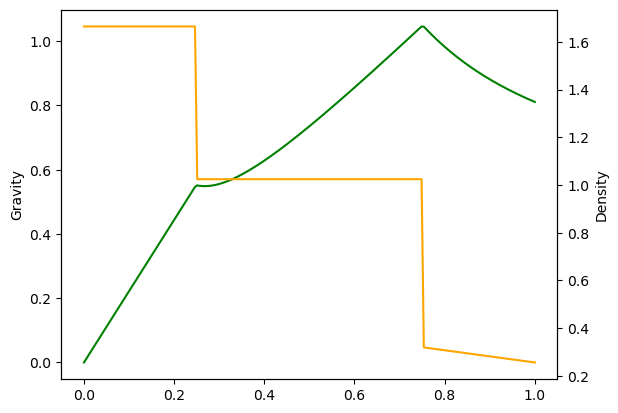

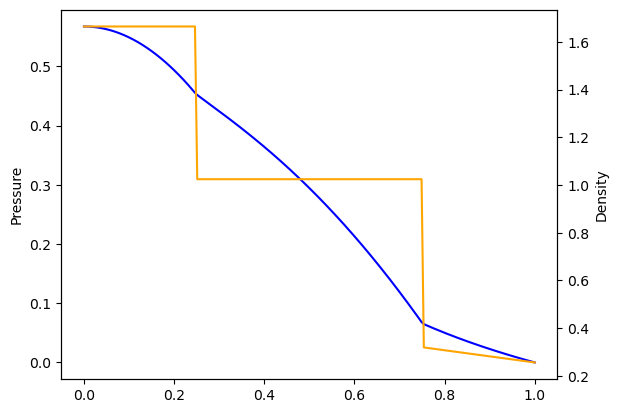

In [6]:
import matplotlib.pyplot as plt

fig1, ax11 = plt.subplots()
ax12 = ax11.twinx()
ax11.plot(radius_array_arr, y_result_arr[0], c='g')
ax12.plot(radius_array_arr, density_array_arr, c='orange')
ax11.set(ylabel='Gravity')
ax12.set(ylabel='Density')


fig2, ax21 = plt.subplots()
ax22 = ax21.twinx()
ax21.plot(radius_array_arr, y_result_arr[1], c='b')
ax22.plot(radius_array_arr, density_array_arr, c='orange')
ax21.set(ylabel='Pressure')
ax22.set(ylabel='Density')

print(f"Centeral Pressure = {y_result_arr[1][0]:0.5e}")
print(f"Surface Gravity = {y_result_arr[0][-1]:0.5e}")

In [7]:
%timeit run()

849 µs ± 8.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
